##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build, train and evaluate models with TensorFlow Decision Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/beginner_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## Introduction

Decision Forests (DF) are a family of Machine Learning algorithms for
supervised classification, regression and ranking. As the name suggests, DFs use
decision trees as a building block. Today, the two most popular DF training
algorithms are [Random Forests](https://en.wikipedia.org/wiki/Random_forest) and
[Gradient Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting).

TensorFlow Decision Forests (TF-DF) is a library for the training,
evaluation, interpretation and inference of Decision Forest models.

In this tutorial, you will learn how to:

1.  Train a multi-class classification Random Forest on a dataset containing numerical, categorical and missing features.
1.  Evaluate the model on a test dataset.
1.  Prepare the model for
    [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).
1.  Examine the overall structure of the model and the importance of each feature.
1.  Re-train the model with a different learning algorithm (Gradient Boosted Decision Trees).
1.  Use a different set of input features.
1.  Change the hyperparameters of the model.
1.  Preprocess the features.
1.  Train a model for regression.

Detailed documentation is available in the [user manual](https://github.com/tensorflow/decision-forests/tree/main/documentation).
The [example directory](https://github.com/tensorflow/decision-forests/tree/main/examples) contains other end-to-end examples.

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [2]:
!pip install tensorflow_decision_forests

Defaulting to user installation because normal site-packages is not writeable


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [3]:
!pip install wurlitzer

Defaulting to user installation because normal site-packages is not writeable


## Importing libraries

In [4]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

2023-07-08 22:13:19.118680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 22:13:19.333100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 22:13:19.334424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 22:13:20.583360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The hidden code cell limits the output height in colab.


In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [6]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.5.0


## Training a Random Forest model

In this section, we train, evaluate, analyse and export a multi-class classification Random Forest trained on the [Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html) dataset.

<center>
<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png" width="150"/></center>

**Note:** The dataset was exported to a csv file without pre-processing: `library(palmerpenguins); write.csv(penguins, file="penguins.csv", quote=F, row.names=F)`. 

### Load the dataset and convert it in a tf.Dataset

This dataset is very small (300 examples) and stored as a .csv-like file. Therefore, use Pandas to load it.

**Note:** Pandas is practical as you don't have to type in name of the input features to load them. For larger datasets (>1M examples), using the
[TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to read the files may be better suited.

Let's assemble the dataset into a csv file (i.e. add the header), and load it:

In [7]:
# Download the dataset
!wget -q https://raw.githubusercontent.com/ideacatlab/test1/main/shuffled_updated.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(15)

primary_naics6_code        website_domain
0               111331      zedencider.co.nz
1               332311          arcedges.com
2               311941  alliedoldenglish.com

The dataset contains a mix of numerical (e.g. `bill_depth_mm`), categorical
(e.g. `island`) and missing features. TF-DF supports all these feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra `is_present` feature.

Labels are a bit different: Keras metrics expect integers. The label (`species`) is stored as a string, so let's convert it into an integer.

In [8]:
# Encode the categorical labels as integers.
#
# Details:
# This stage is necessary if your classification label is represented as a
# string since Keras expects integer classification labels.
# When using `pd_dataframe_to_tf_dataset` (see below), this step can be skipped.

# Name of the label column.
label = "primary_naics6_code"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: [111331, 332311, 311941, 326191, 212312, 713950, 621511, 334512, 541410, 531320, 423710, 111160, 324121, 332410, 623110, 424810, 325411, 713110, 562111, 541850, 332510, 541310, 331318, 423820, 331315, 339992, 611699, 561621, 335931, 561730, 333241, 332119, 321912, 519210, 112130, 445132, 713920, 541320, 314120, 621391, 336350, 925110, 812111, 423830, 621498, 512199, 711110, 335313, 812332, 923140, 112120, 339113, 313110, 337910, 236210, 333992, 449122, 813312, 112910, 522291, 924120, 459310, 336320, 541618, 532310, 339115, 332811, 541620, 621991, 238350, 238110, 611512, 333515, 531120, 321215, 513130, 711310, 444230, 332813, 336214, 523991, 493120, 561790, 449110, 212290, 541199, 921150, 112340, 333618, 336212, 237310, 333993, 423210, 561920, 115116, 334412, 624221, 541211, 531311, 519290, 456130, 525990, 455219, 339994, 424480, 532420, 517410, 532111, 212114, 326140, 315990, 455110, 562212, 561710, 327331, 493190, 444240, 424110, 621493, 326211, 425120, 327212, 333998, 

Next split the dataset into training and testing:

In [9]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.05):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

156684 examples in training, 8259 examples for testing.


And finally, convert the pandas dataframe (`pd.Dataframe`) into tensorflow datasets (`tf.data.Dataset`):

In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, max_num_classes=1000)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, max_num_classes=1000)

**Notes:** Recall that `pd_dataframe_to_tf_dataset` converts string labels to integers if necessary.

If you want to create the `tf.data.Dataset` yourself, there are a couple of things to remember:

- The learning algorithms work with a one-epoch dataset and without shuffling.
- The batch size does not impact the training algorithm, but a small value might slow down reading the dataset.


### Train the model

In [11]:
%set_cell_height 156684

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model.
model_1.fit(train_ds)

<IPython.core.display.Javascript object>

Use 8 thread(s) for training
Use /tmp/tmpck475iim as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'website_domain': <tf.Tensor 'data:0' shape=(None,) dtype=string>}
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'website_domain': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>)}
Training dataset read in 0:00:02.965528. Found 156684 examples.
Training model...
Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training gets stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO 23-07-08 22:15:04.8522 EEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-08 22:15:04.8523 EEST kernel.cc:774] Collect training examples
[INFO 23-07-08 22:15:04.8523 EEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-08 22:15:04.8531 EEST kernel.cc:393] Number of batches: 157
[INFO 23-07-08 22:15:04.8532 EEST kernel.cc:394] Number of examples: 156684
[INFO 23-07-08 22:15:04.9702 EEST data_spec_inference.cc:305] 156682 item(s) have been pruned (i.e. they are considered out of dictionary) for the column website_domain (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 23-07-08 22:15:05.024

Model trained in 0:00:10.875151
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


### Remarks

-   No input features are specified. Therefore, all the columns will be used as
    input features except for the label. The feature used by the model are shown
    in the training logs and in the `model.summary()`.
-   DFs consume natively numerical, categorical, categorical-set features and
    missing-values. Numerical features do not need to be normalized. Categorical
    string values do not need to be encoded in a dictionary.
-   No training hyper-parameters are specified. Therefore the default
    hyper-parameters will be used. Default hyper-parameters provide
    reasonable results in most situations.
-   Calling `compile` on the model before the `fit` is optional. Compile can be
    used to provide extra evaluation metrics.
-   Training algorithms do not need validation datasets. If a validation dataset
    is provided, it will only be used to show metrics.
-   Tweak the `verbose` argument to `RandomForestModel` to control the amount of
    displayed training logs. Set `verbose=0` to hide most of the logs. Set
    `verbose=2` to show all the logs.

**Note:** A *Categorical-Set* feature is composed of a set of categorical values (while a *Categorical* is only one value). More details and examples are given later.

## Evaluate the model

Let's evaluate our model on the test dataset.

In [12]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

9/9 [==============================] - 2s 229ms/step - loss: 0.0000e+00 - accuracy: 4.8432e-04

loss: 0.0000
accuracy: 0.0005


**Remark:** The test accuracy is close to the Out-of-bag accuracy
shown in the training logs.

See the **Model Self Evaluation** section below for more evaluation methods.

## Prepare this model for TensorFlow Serving.

Export the model to the SavedModel format for later re-use e.g.
[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).


In [13]:
model_1.save("/tmp/my_saved_model")

INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


## Plot the model

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interesting to plan than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest model:

In [14]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node on the left contains the first condition (`bill_depth_mm >= 16.55`), number of examples (240) and label distribution (the red-blue-green bar).

Examples that evaluates true to `bill_depth_mm >= 16.55` are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more `pure` they become i.e. the label distribution is biased toward a subset of classes. 

**Note:** Over the mouse on top of the plot for details.

## Model structure and feature importance

The overall structure of the model is show with `.summary()`. You will see:

-   **Type**: The learning algorithm used to train the model (`Random Forest` in
    our case).
-   **Task**: The problem solved by the model (`Classification` in our case).
-   **Input Features**: The input features of the model.
-   **Variable Importance**: Different measures of the importance of each
    feature for the model.
-   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a
    cheap and efficient alternative to cross-validation.
-   **Number of {trees, nodes} and other metrics**: Statistics about the
    structure of the decisions forests.

**Remark:** The summary's content depends on the learning algorithm (e.g.
Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g.
the *mean-decrease-in-accuracy* variable importance can be disabled in the
hyper-parameters).

In [15]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (1):
	website_domain

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:

Variable Importance: NUM_AS_ROOT:

Variable Importance: NUM_NODES:

Variable Importance: SUM_SCORE:



Winner takes all: true
Out-of-bag evaluation: accuracy:0.000733961 logloss:32.9784
Number of trees: 300
Total number of nodes: 300

Number of nodes by tree:
Count: 300 Average: 1 StdDev: 0
Min: 1 Max: 1 Ignored: 0
----------------------------------------------
[ 1, 1] 300 100.00% 100.00% ##########

Depth by leafs:
Count: 300 Average: 0 StdDev: 0
Min: 0 Max: 0 Ignored: 0
----------------------------------------------
[

The information in ``summary`` are all available programmatically using the model inspector:

In [16]:
# The input features
model_1.make_inspector().features()

["website_domain" (4; #1)]

In [17]:
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [], 'NUM_NODES': [], 'SUM_SCORE': [], 'INV_MEAN_MIN_DEPTH': []}

The content of the summary and the inspector depends on the learning algorithm (`tfdf.keras.RandomForestModel` in this case) and its hyper-parameters (e.g. `compute_oob_variable_importances=True` will trigger the computation of Out-of-bag variable importances for the Random Forest learner).

## Model Self Evaluation

During training TFDF models can self evaluate even if no validation dataset is provided to the `fit()` method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note:** While this evaluation is  computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation.

The model self evaluation is available with the inspector's `evaluation()`:

In [18]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=156684, accuracy=0.0007339613489571366, loss=32.97836189974575, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

## Plotting the training logs

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality.

The logs are available in multiple ways:

1. Displayed in during training if `fit()` is wrapped in `with sys_pipes():` (see example above).
1. At the end of the model summary i.e. `model.summary()` (see example above).
1. Programmatically, using the model inspector i.e. `model.make_inspector().training_logs()`.
1. Using [TensorBoard](https://www.tensorflow.org/tensorboard)

Let's try the options 2 and 3:


In [19]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=57622, accuracy=0.00114539585574954, loss=36.002367331663805, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=155676, accuracy=0.0009442688661065289, loss=35.898934140278804, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=156674, accuracy=0.0009893153937475267, loss=35.78250152646825, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=156684, accuracy=0.001091368614536264, loss=35.666804605342925, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=156684, accuracy=0.0009956345255418548, loss=35.5572392067884, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=156684, accuracy=0.0009190472543463276, loss

Let's plot it:

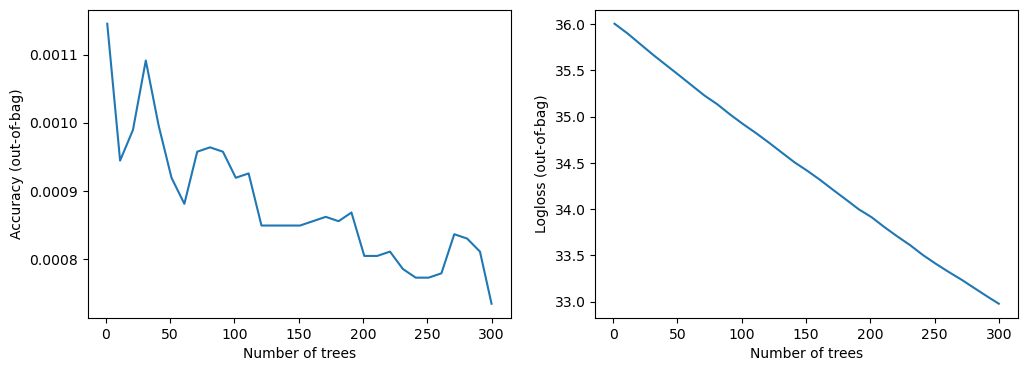

In [20]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard:

In [21]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [22]:
# Clear existing results (if any)
!rm -fr "/tmp/tensorboard_logs"

In [23]:
# Export the meta-data to tensorboard.
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [24]:
# docs_infra: no_execute
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

<!-- <img class="tfo-display-only-on-site" src="images/beginner_tensorboard.png"/> -->


## Re-train the model with a different learning algorithm

The learning algorithm is defined by the model class. For
example, `tfdf.keras.RandomForestModel()` trains a Random Forest, while
`tfdf.keras.GradientBoostedTreesModel()` trains a Gradient Boosted Decision
Trees.

The learning algorithms are listed by calling `tfdf.keras.get_all_models()` or in the
[learner list](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

In [25]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

The description of the learning algorithms and their hyper-parameters are also available in the [API reference](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf) and builtin help:

In [27]:
# help works anywhere.
help(tfdf.keras.RandomForestModel)


Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(task: Optional[ForwardRef('abstract_model_pb2.Task')] = 1, features: Optional[List[tensorflow_decision_forests.keras.core.FeatureUsage]] = None, exclude_non_specified_features: Optional[bool] = False, preprocessing: Optional[ForwardRef('tf.keras.models.Functional')] = None, postprocessing: Optional[ForwardRef('tf.keras.models.Functional')] = None, ranking_group: Optional[str] = None, uplift_treatment: Optional[str] = None, temp_directory: Optional[str] = None, verbose: int = 1, hyperparameter_template: Optional[str] = None, advanced_arguments: Optional[tensorflow_decision_forests.keras.core_inference.AdvancedArguments] = None, num_threads: Optional[int] = None, name: Optional[str] = None, max_vocab_count: Optional[int] = 2000, try_resume_training: Optional[bool] = True, check_dataset: Optional[bool] = T

## Using a subset of features

The previous example did not specify the features, so all the columns were used
as input feature (except for the label). The following example shows how to
specify input features.

In [29]:
feature_1 = tfdf.keras.FeatureUsage(name="website_domain")

all_features = [feature_1]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features.

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features)

model_2.compile(metrics=["accuracy"])
model_2.fit(train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

Use /tmp/tmp2pntr64_ as temporary training directory
Reading training dataset...


[WARNING 23-07-08 22:20:37.6254 EEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-08 22:20:37.6254 EEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-08 22:20:37.6254 EEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.338037. Found 156684 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(8259, shape=(), dtype=int32)
Validation dataset read in 0:00:00.171258. Found 8259 examples.
Training model...


[INFO 23-07-08 22:26:26.9784 EEST kernel.cc:1243] Loading model from path /tmp/tmp2pntr64_/model/ with prefix 2ad96724c2384b02


Model trained in 0:05:49.545190
Compiling model...


[WARNING 23-07-08 22:26:27.6740 EEST utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 23-07-08 22:26:27.6756 EEST decision_forest.cc:660] Model loaded with 40076 root(s), 40076 node(s), and 0 input feature(s).
[INFO 23-07-08 22:26:27.6756 EEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-08 22:26:27.6756 EEST kernel.cc:1075] Use fast generic engine


Model compiled.
9/9 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - accuracy: 1.2108e-04
{'loss': 0.0, 'accuracy': 0.00012108003284083679}


**Note:** As expected, the accuracy is lower than previously.

**TF-DF** attaches a **semantics** to each feature. This semantics controls how
the feature is used by the model. The following semantics are currently supported:

-   **Numerical**: Generally for quantities or counts with full ordering. For
    example, the age of a person, or the number of items in a bag. Can be a
    float or an integer. Missing values are represented with float(Nan) or with
    an empty sparse tensor.
-   **Categorical**: Generally for a type/class in finite set of possible values
    without ordering. For example, the color RED in the set {RED, BLUE, GREEN}.
    Can be a string or an integer. Missing values are represented as "" (empty
    sting), value -2 or with an empty sparse tensor.
-   **Categorical-Set**: A set of categorical values. Great to represent
    tokenized text. Can be a string or an integer in a sparse tensor or a
    ragged tensor (recommended). The order/index of each item doesn't matter.

If not specified, the semantics is inferred from the representation type and shown in the training logs:

- int, float (dense or sparse) → Numerical semantics.
- str (dense or sparse) → Categorical semantics
- int, str (ragged) → Categorical-Set semantics

In some cases, the inferred semantics is incorrect. For example: An Enum stored as an integer is semantically categorical, but it will be detected as numerical. In this case, you should specify the semantic argument in the input. The `education_num` field of the Adult dataset is classical example.

This dataset doesn't contain such a feature. However, for the demonstration, we will make the model treat the `year` as a categorical feature:

In [30]:
%set_cell_height 300

feature_1 = tfdf.keras.FeatureUsage(name="website_domain", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
all_features = [feature_1]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

model_3.fit(train_ds, validation_data=test_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmp2dpcmq7i as temporary training directory
Reading training dataset...


[WARNING 23-07-08 22:28:30.6033 EEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-08 22:28:30.6033 EEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-08 22:28:30.6033 EEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.295410. Found 156684 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(8259, shape=(), dtype=int32)
Validation dataset read in 0:00:00.114016. Found 8259 examples.
Training model...


[INFO 23-07-08 22:34:19.3589 EEST kernel.cc:1243] Loading model from path /tmp/tmp2dpcmq7i/model/ with prefix ed4b239e95944964


Model trained in 0:05:48.896971
Compiling model...


[WARNING 23-07-08 22:34:19.9046 EEST utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 23-07-08 22:34:19.9061 EEST decision_forest.cc:660] Model loaded with 40076 root(s), 40076 node(s), and 0 input feature(s).
[INFO 23-07-08 22:34:19.9061 EEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-08 22:34:19.9061 EEST kernel.cc:1075] Use fast generic engine


Model compiled.


In [33]:
model_3.compile(metrics=["accuracy"])
evaluation = model_3.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


9/9 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - accuracy: 1.2108e-04

loss: 0.0000
accuracy: 0.0001


Note that `year` is in the list of CATEGORICAL features (unlike the first run).

## Hyper-parameters

**Hyper-parameters** are parameters of the training algorithm that impact
the quality of the final model. They are specified in the model class
constructor. The list of hyper-parameters is visible with the *question mark* colab command (e.g. `?tfdf.keras.GradientBoostedTreesModel`).

Alternatively, you can find them on the [TensorFlow Decision Forest Github](https://github.com/tensorflow/decision-forests/blob/main/tensorflow_decision_forests/keras/wrappers_pre_generated.py) or the [Yggdrasil Decision Forest documentation](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

The default hyper-parameters of each algorithm matches approximatively the initial publication paper. To ensure consistancy, new features and their matching hyper-parameters are always disable by default. That's why it is a good idea to tune your hyper-parameters.

In [31]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.fit(train_ds)

Use /tmp/tmppsnzxuaq as temporary training directory
Reading training dataset...


[WARNING 23-07-08 22:37:54.3437 EEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-08 22:37:54.3438 EEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-08 22:37:54.3438 EEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.319010. Found 156684 examples.
Training model...


[INFO 23-07-08 22:43:47.7747 EEST kernel.cc:1243] Loading model from path /tmp/tmppsnzxuaq/model/ with prefix 6bf42baaefd747f9


Model trained in 0:05:54.211268
Compiling model...


[WARNING 23-07-08 22:43:48.8488 EEST utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 23-07-08 22:43:48.8536 EEST decision_forest.cc:660] Model loaded with 64308 root(s), 64308 node(s), and 0 input feature(s).
[INFO 23-07-08 22:43:48.8536 EEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-08 22:43:48.8536 EEST kernel.cc:1075] Use fast generic engine


Model compiled.


In [32]:
model_6.compile(metrics=["accuracy"])
evaluation = model_6.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")



9/9 [==============================] - 5s 514ms/step - loss: 0.0000e+00 - accuracy: 8.4756e-04

loss: 0.0000
accuracy: 0.0008


In [ ]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.fit(train_ds)

As new training methods are published and implemented, combination of hyper-parameters can emerge as good or almost-always-better than the default parameters. To avoid changing the default hyper-parameter values these good combination are indexed and available as hyper-parameter templates.

For example, the `benchmark_rank1` template is the best combination on our internal benchmarks. Those templates are versioned to allow training configuration stability e.g. `benchmark_rank1@v1`.

In [ ]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(train_ds)

The available templates are available with `predefined_hyperparameters`. Note that different learning algorithms have different templates, even if the name is similar.

In [ ]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

## Feature Preprocessing

Pre-processing features is sometimes necessary to consume signals with complex
structures, to regularize the model or to apply transfer learning.
Pre-processing can be done in one of three ways:

1.  Preprocessing on the Pandas dataframe. This solution is easy to implement
    and generally suitable for experimentation. However, the
    pre-processing logic will not be exported in the model by `model.save()`.

2.  [Keras Preprocessing](https://keras.io/guides/preprocessing_layers/): While
    more complex than the previous solution, Keras Preprocessing is packaged in
    the model.

3.  [TensorFlow Feature Columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns):
    This API is part of the TF Estimator library (!= Keras) and planned for
    deprecation. This solution is interesting when using existing preprocessing
    code.

Note: Using [TensorFlow Hub](https://www.tensorflow.org/hub)
pre-trained embedding is often, a great way to consume text and image with
TF-DF. For example, `hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")`. See the [Intermediate tutorial](intermediate_colab.ipynb) for more details.

In the next example, pre-process the `body_mass_g` feature into `body_mass_kg = body_mass_g / 1000`. The `bill_length_mm` is consumed without pre-processing. Note that such
monotonic transformations have generally no impact on decision forest models.

In [ ]:
%set_cell_height 300

body_mass_g = tf.keras.layers.Input(shape=(1,), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1,), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}

# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(train_ds)

model_4.summary()

The following example re-implements the same logic using TensorFlow Feature
Columns.

In [ ]:
def g_to_kg(x):
  return x / 1000

feature_columns = [
    tf.feature_column.numeric_column("body_mass_g", normalizer_fn=g_to_kg),
    tf.feature_column.numeric_column("bill_length_mm"),
]

preprocessing = tf.keras.layers.DenseFeatures(feature_columns)

model_5 = tfdf.keras.RandomForestModel(preprocessing=preprocessing)
model_5.fit(train_ds)

## Training a regression model

The previous example trains a classification model (TF-DF does not differentiate
between binary classification and multi-class classification). In the next
example, train a regression model on the
[Abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone). The
objective of this dataset is to predict the number of shell's rings of an
abalone.

**Note:** The csv file is assembled by appending UCI's header and data files. No preprocessing was applied.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/LivingAbalone.JPG/800px-LivingAbalone.JPG" width="200"/></center>

In [50]:
# Download the dataset.
!wget -q https://raw.githubusercontent.com/ideacatlab/test1/main/shuffled_updated.csv -O /tmp/abalone.csv

dataset_df = pd.read_csv("/tmp/abalone.csv")
print(dataset_df.head(3))

   primary_naics6_code        website_domain
0               111331      zedencider.co.nz
1               332311          arcedges.com
2               311941  alliedoldenglish.com


In [51]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Name of the label column.
label = "primary_naics6_code"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

115406 examples in training, 49537 examples for testing.


In [52]:
%set_cell_height 300

# Configure the model.
model_7 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Train the model.
model_7.fit(train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmpwbc_09yk as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.389143. Found 115406 examples.
Training model...
Model trained in 0:00:01.650016
Compiling model...


[INFO 23-07-08 22:05:47.8389 EEST kernel.cc:1243] Loading model from path /tmp/tmpwbc_09yk/model/ with prefix c01b64454f5b403f
[WARNING 23-07-08 22:05:47.8414 EEST utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO 23-07-08 22:05:47.8415 EEST decision_forest.cc:660] Model loaded with 300 root(s), 300 node(s), and 0 input feature(s).
[INFO 23-07-08 22:05:47.8415 EEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-08 22:05:47.8416 EEST kernel.cc:1075] Use fast generic engine


Model compiled.


In [53]:
# Evaluate the model on the test dataset.
model_7.compile(metrics=["mse"])
evaluation = model_7.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

50/50 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mse: 229947572224.0000
{'loss': 0.0, 'mse': 229947572224.0}

MSE: 229947572224.0
RMSE: 479528.48948107345


In [54]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]